In [1]:
import pandas as pd

# Chemins relatifs
train_path = "projet_data/train.csv"

# --------------
# Import "classique" pour le TRAIN
train_df = pd.read_csv(train_path, encoding="latin-1", sep=",", on_bad_lines='skip')

# Affichage des colonnes
print("Colonnes du fichier TRAIN :")
print(train_df.columns)


Colonnes du fichier TRAIN :
Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²);;;;;;;;;;;;'],
      dtype='object')


Maintenant que l'importation de nos données sont OK, on peut passer au nettoyage des deux datasets.

In [2]:
import re
import string

def nettoyer_texte(tweet):
    # 1. Supprimer les mentions @xxx
    tweet = re.sub(r'@\w+', '', tweet)
    # 2. Garder les hashtags mais sans le # (option très utile pour sentiment)
    tweet = re.sub(r'#(\w+)', r'\1', tweet)
    # 3. Supprimer les URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)
    # 4. Garder les emojis (ils sont très informatifs pour le sentiment)
    # 5. Supprimer la ponctuation SAUF les emojis (garde !, ?, etc. pour renforcer l'émotion)
    #    Ici, on enlève la ponctuation "classique" mais on garde ! et ? par exemple :
    tweet = tweet.translate(str.maketrans('', '', string.punctuation.replace('!', '').replace('?', '')))
    # 6. Mettre en minuscule
    tweet = tweet.lower()
    # 7. Supprimer les chiffres (optionnel, tu peux commenter si besoin)
    tweet = re.sub(r'\d+', '', tweet)
    # 8. Supprimer les espaces multiples
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

In [3]:
# Créer une nouvelle colonne "clean_text" pour le fichier d'entrainement (train)
train_df["clean_text"] = train_df["text"].astype(str).apply(nettoyer_texte)
# Afficher les 5 premières lignes brutes/nettoyées
print(train_df[["text", "clean_text"]].head())

                                             text  \
0                                             NaN   
1   Sooo SAD I will miss you here in San Diego!!!   
2                       my boss is bullying me...   
3                  what interview! leave me alone   
4                                             NaN   

                                      clean_text  
0                                            nan  
1  sooo sad i will miss you here in san diego!!!  
2                         my boss is bullying me  
3                 what interview! leave me alone  
4                                            nan  


On peut voir ici qu'on a supprimé ce qui pourrait polluer notre dataset.

Notre objectif maintenant va être d'entrainer notre modèle sur le fichier 'train', pour pouvoir créer une prédiction sur la colonne sentiment.

In [4]:
# Vérifier que la colonne sentiments contient des sentiments valides
print(train_df["sentiment"].unique())


[nan 'negative' 'neutral' 'positive' 'morning' 'night' 'noon']


On peut voir qu'il y a des sentiments en trop dans notre jeu de données. Il faudra donc le nettoyer.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Nettoyage des NaN et des sentiments invalides
train_df = train_df.dropna(subset=["clean_text", "sentiment"])
sentiments_valides = ['positive', 'negative', 'neutral']
train_df = train_df[train_df["sentiment"].isin(sentiments_valides)]

# Séparation features/labels
X = train_df["clean_text"].astype(str)
y = train_df["sentiment"]

# Séparation 90% train / 10% validation (stratifiée pour respecter la proportion des classes)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.10, 
    random_state=42, 
    stratify=y
)

# Vectorisation TF-IDF sur les données d'entraînement
vectorizer = TfidfVectorizer(max_features=25000)
X_train_vect = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)  # attention : transform, pas fit_transform !

# Entraînement du modèle sur le train
model = LogisticRegression(max_iter=200)
model.fit(X_train_vect, y_train)

# Prédiction sur la validation
y_val_pred = model.predict(X_val_vect)

# Rapport de performance
print("Rapport de classification sur le jeu de validation :\n")
print(classification_report(y_val, y_val_pred))


Rapport de classification sur le jeu de validation :

              precision    recall  f1-score   support

    negative       0.73      0.59      0.65       596
     neutral       0.62      0.77      0.69       854
    positive       0.80      0.69      0.74       639

    accuracy                           0.69      2089
   macro avg       0.72      0.68      0.69      2089
weighted avg       0.71      0.69      0.69      2089



Maintenant, on va utiliser le randomforst pour comparer les résultats et voir si les deux correspondent.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Vectorisation n-grammes (optionnel, mais recommandé avec RF)
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))  # Réduis max_features si tu veux que ce soit plus rapide
X_train_vect = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)

# Entraînement du modèle Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Nombre d'arbres (100 est un bon compromis)
    random_state=42,
    n_jobs=-1         # Utilise tous les cœurs CPU
)
rf_model.fit(X_train_vect, y_train)

# Prédiction sur la validation
y_val_pred_rf = rf_model.predict(X_val_vect)

# Rapport de performance
print("Rapport de classification avec Random Forest :\n")
print(classification_report(y_val, y_val_pred_rf))


Rapport de classification avec Random Forest :

              precision    recall  f1-score   support

    negative       0.76      0.49      0.60       596
     neutral       0.60      0.81      0.69       854
    positive       0.82      0.69      0.75       639

    accuracy                           0.68      2089
   macro avg       0.72      0.66      0.68      2089
weighted avg       0.71      0.68      0.68      2089



Pour mieux comprendre les résutlats, on a 2000 tweets qui ont été traités car on a fait l'analyse sur 20 000 tweets, et créé un test sur 10% de ces 20 000. Ainsi le modèle s'entraine sur 18 000 tweets, et vérifie les résultats sur les 2000 réstants.  

Ensuite, on a :  
    - 596 négatifs, avec une précision de 75%  
    - 854 neutres, avec une précision de 60%  
    - 639 positifs, avec une précision de 82%  

Le modèle à donc 68% de précison.

In [7]:
phrases = [
    "Okay.",
    "Could be better, could be worse.",
    "Absolutely fantastic work!",
    "I'm so angry right now.",
    "It's just another regular day.",
    "Meh, nothing special.",
    "Best experience ever!",
    "Worst experience ever.",
    "I have no strong feelings one way or the other."
]

# Nettoyage des phrases
clean_phrases = [nettoyer_texte(p) for p in phrases]

# Vectorisation (le vectorizer doit être déjà "fit" sur le train !)
X_phrases_vect = vectorizer.transform(clean_phrases)

# Prédiction du sentiment
sentiments_pred = rf_model.predict(X_phrases_vect)

# Affichage des résultats
for phrase, sentiment in zip(phrases, sentiments_pred):
    print(f'Phrase : {phrase}\n → Prédiction : {sentiment}\n')

Phrase : Okay.
 → Prédiction : neutral

Phrase : Could be better, could be worse.
 → Prédiction : positive

Phrase : Absolutely fantastic work!
 → Prédiction : positive

Phrase : I'm so angry right now.
 → Prédiction : negative

Phrase : It's just another regular day.
 → Prédiction : neutral

Phrase : Meh, nothing special.
 → Prédiction : neutral

Phrase : Best experience ever!
 → Prédiction : positive

Phrase : Worst experience ever.
 → Prédiction : negative

Phrase : I have no strong feelings one way or the other.
 → Prédiction : neutral



On peut voir que sur ces tests, la prédiction semble bien fonctionner.

Maintenant, on va essayer de trouver uen corrélation entre l'heure du tweet et le sentiment qu'il en dégage.  
On va donc tout d'abord regarder quelles sont les horraires que nous avons dans la colonne 'Time of Tweet'.

In [8]:
distinct_times = train_df['Time of Tweet'].unique()
print(distinct_times)

['noon' 'night' 'morning']


In [9]:
# Si ta colonne s'appelle "date" ou "Time of Tweet"
def extraire_heure(chaine):
    match = re.search(r'\s(\d{2}):\d{2}:\d{2}\s', chaine)
    if match:
        return int(match.group(1))
    else:
        return None

# Suppose que le DataFrame s'appelle "train_df" et la colonne "date"
train_df["hour"] = train_df["Time of Tweet"].apply(extraire_heure)

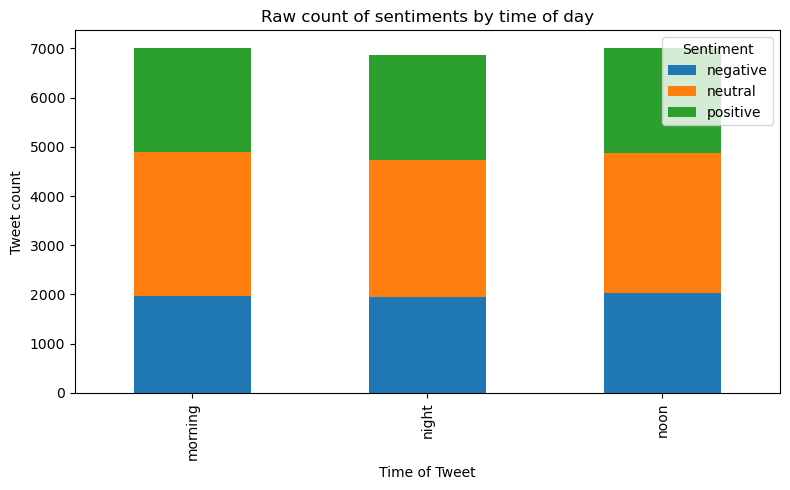

In [10]:
import matplotlib.pyplot as plt

# Comptage du nombre de tweets par période et par sentiment
sentiment_par_periode = train_df.groupby(["Time of Tweet", "sentiment"]).size().unstack(fill_value=0)

# Pourcentage pour chaque période (optionnel)
sentiment_pct_par_periode = sentiment_par_periode.div(sentiment_par_periode.sum(axis=1), axis=0)

# Affichage
sentiment_par_periode.plot(kind="bar", stacked=True, figsize=(8, 5))
plt.title("Raw count of sentiments by time of day")
plt.xlabel("Time of Tweet")
plt.ylabel("Tweet count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


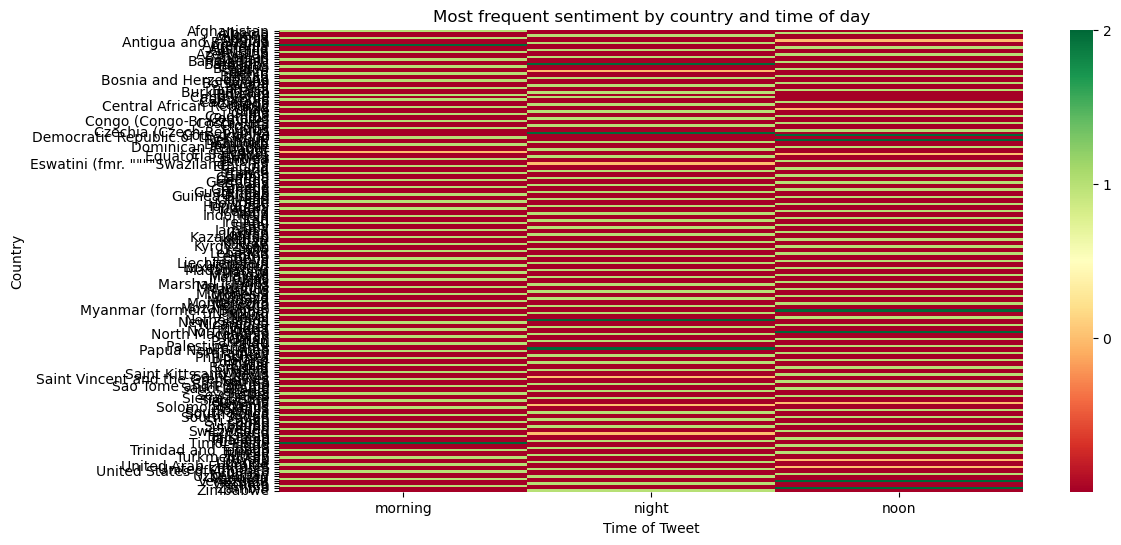

In [11]:
import seaborn as sns

# Prend le sentiment majoritaire par pays et période
sentiment_mode = train_df.groupby(["Country", "Time of Tweet"])["sentiment"].agg(lambda x: x.value_counts().idxmax())
sentiment_mode = sentiment_mode.unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(sentiment_mode.apply(lambda x: pd.Categorical(x, categories=["negative", "neutral", "positive"]).codes), 
            cmap="RdYlGn", cbar_kws={"ticks":[0,1,2]}, yticklabels=True)
plt.title("Most frequent sentiment by country and time of day")
plt.xlabel("Time of Tweet")
plt.ylabel("Country")
plt.show()


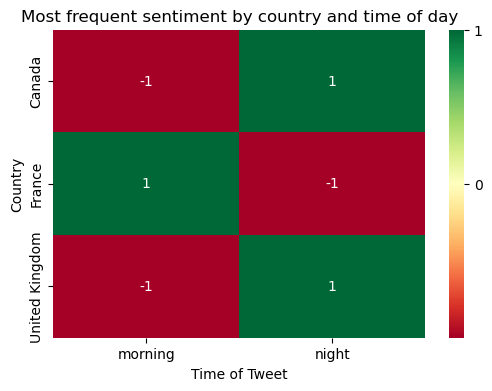

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Liste des pays à garder (utilise exactement le nom qui apparaît dans ta colonne 'Country')
pays_focus = ["Canada", "France", "United Kingdom"]

# Filtrer le DataFrame
train_df_focus = train_df[train_df["Country"].isin(pays_focus)]

# Calcul du sentiment majoritaire par pays et période
sentiment_mode = train_df_focus.groupby(["Country", "Time of Tweet"])["sentiment"].agg(lambda x: x.value_counts().idxmax())
sentiment_mode = sentiment_mode.unstack()

plt.figure(figsize=(6, 4))
sns.heatmap(
    sentiment_mode.apply(lambda x: pd.Categorical(x, categories=["negative", "neutral", "positive"]).codes), 
    cmap="RdYlGn", 
    cbar_kws={"ticks":[0,1,2]}, 
    yticklabels=True,
    annot=True, fmt="d"
)
plt.title("Most frequent sentiment by country and time of day")
plt.xlabel("Time of Tweet")
plt.ylabel("Country")
plt.show()


In [13]:
def predict_tweet_sentiment(tweet_text, time_of_day, country, 
                            model=rf_model, vectorizer=vectorizer, 
                            tendance_df=None):
    """
    Prédit le sentiment d'un tweet selon le texte, l'heure, et le pays,
    et compare à la tendance majoritaire du pays/heure dans le dataset.
    - tweet_text: str, le texte du tweet
    - time_of_day: "morning", "noon", "night"
    - country: nom du pays (ex: "France")
    - model, vectorizer: ton modèle entraîné et ton vectorizer (par défaut ceux du notebook)
    - tendance_df: DataFrame à deux niveaux (Country, Time of Tweet) donnant le sentiment majoritaire
    """
    # Nettoyage du texte
    clean = nettoyer_texte(tweet_text)
    # Vectorisation
    vect = vectorizer.transform([clean])
    # Prédiction du modèle
    pred_sentiment = model.predict(vect)[0]
    
    # Récupère la tendance majoritaire du pays/heure si dispo
    tendance = None
    if tendance_df is not None:
        try:
            tendance = tendance_df.loc[country, time_of_day]
        except KeyError:
            tendance = None
    
    print(f"Texte : {tweet_text}")
    print(f"Moment : {time_of_day} / Pays : {country}")
    print(f"=> Prédiction du modèle : {pred_sentiment}")
    if tendance is not None:
        print(f"Tendance majoritaire du pays/heure dans le dataset : {tendance}")
    else:
        print("(Pas de tendance locale trouvée dans le dataset)")
    return pred_sentiment

# --- Construction de la DataFrame de tendance majoritaire par pays/période ---
# (à faire une fois)
tendance_mode = train_df.groupby(["Country", "Time of Tweet"])["sentiment"].agg(lambda x: x.value_counts().idxmax())
# C'est une Series indexée par (Country, Time of Tweet)

# --- Exemple d'utilisation ---
tweet = "I love this product! It made my day so much better."
moment = "morning"
pays = "France"

predict_tweet_sentiment(tweet, moment, pays, 
                        model=rf_model, vectorizer=vectorizer, 
                        tendance_df=tendance_mode)


Texte : I love this product! It made my day so much better.
Moment : morning / Pays : France
=> Prédiction du modèle : positive
Tendance majoritaire du pays/heure dans le dataset : neutral


'positive'

In [14]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

# 1. Nettoyage et préparation du texte (déjà fait)
X_text = train_df["clean_text"]
y = train_df["sentiment"]

# 2. Vectorisation du texte
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_text_vect = vectorizer.fit_transform(X_text)

# 3. Encodage one-hot du pays et du moment
encoder = OneHotEncoder(handle_unknown='ignore')
X_categorical = encoder.fit_transform(train_df[["Country", "Time of Tweet"]])

# 4. Fusion des features texte + catégorielles
from scipy.sparse import hstack
X_combined = hstack([X_text_vect, X_categorical])

# 5. Train/test split comme avant (ex: 90/10)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.1, random_state=42, stratify=y)

# 6. Modélisation (RandomForest conseillé pour ce mélange de features)
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 7. Prédiction et rapport
from sklearn.metrics import classification_report
y_val_pred = rf_model.predict(X_val)
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

    negative       0.75      0.48      0.59       596
     neutral       0.59      0.80      0.68       854
    positive       0.79      0.68      0.73       639

    accuracy                           0.67      2089
   macro avg       0.71      0.65      0.67      2089
weighted avg       0.70      0.67      0.67      2089



In [15]:
def predict_sentiment_with_context(tweet_text, time_of_day, country, 
                                   vectorizer=vectorizer, encoder=encoder, model=rf_model):
    # Nettoyage
    clean = nettoyer_texte(tweet_text)
    # Vectorisation texte
    X_text = vectorizer.transform([clean])
    # Encodage des variables catégorielles
    X_cat = encoder.transform([[country, time_of_day]])
    # Concaténation
    X_all = hstack([X_text, X_cat])
    # Prédiction
    sentiment = model.predict(X_all)[0]
    return sentiment

# Exemple
sentiment = predict_sentiment_with_context(
    "Okay", "morning", "United Kingdom"
)
print(f"Sentiment prédit : {sentiment}")


Sentiment prédit : neutral


c:\Users\bonni\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [16]:
import joblib

# Sauvegarder le vectorizer
joblib.dump(vectorizer, "models/vectorizer.joblib")

# Sauvegarder l’encoder
joblib.dump(encoder, "models/encoder.joblib")

# Sauvegarder le modèle Random Forest
joblib.dump(rf_model, "models/rf_model.joblib")


['models/rf_model.joblib']